# Random Forest


Libraries and data.

In [95]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Data
# X_train_df = pd.read_csv('gold/X_train_df.csv', index_col='respondent_id') # training set features
h1n1_X_train_df = pd.read_csv('../data/gold/h1n1_X_train_df.csv', index_col='respondent_id') # training set features
seasonal_X_train_df = pd.read_csv('../data/gold/seasonal_X_train_df.csv', index_col='respondent_id') # training set features


training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

# X_test_df = pd.read_csv('gold/X_test_df.csv', index_col='respondent_id') # test set features
h1n1_X_test_df = pd.read_csv('../data/gold/h1n1_X_test_df.csv', index_col='respondent_id') # test set features
seasonal_X_test_df = pd.read_csv('../data/gold/seasonal_X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

Data split for h1n1 and seasonal (each with its own variables).

In [96]:
h1n1_X_train, h1n1_X_test, h1n1_y_train, h1n1_y_test = train_test_split(h1n1_X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)
seasonal_X_train, seasonal_X_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

Cross-validation.

In [97]:
# # Set up the MultiOutputClassifier with Random Forest Regressor
# multi_output_clf = MultiOutputClassifier(RandomForestClassifier(random_state=42))

In [98]:
# # Let's do GridSearchCV
# # parameters grid
# param_grid = {
#     "estimator__n_estimators": [50, 100, 200],
#     "estimator__criterion" : ["gini", "entropy"],
#     "estimator__max_depth" : [None, 5, 10, 20, 30],
#     "estimator__min_samples_split" : [2, 5, 10],
#     "estimator__min_samples_leaf": [1, 2, 4],
#     "estimator__class_weight" :['balanced', 'balanced_subsample'],
#     "estimator__bootstrap" : [True, False]            # Si usar o no remuestreo (bootstrap). 
#     # class weight should be balanced or balanced_subsample - we have imbalance issue.
# }

In [99]:
# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters from Grid Search:", grid_search.best_params_)
# print("Best Score from Grid Search:", grid_search.best_score_)

# # Evaluate on the test set
# y_pred_grid = grid_search.predict(X_test)
# mse_grid = mean_squared_error(y_test, y_pred_grid)
# print(f"Mean Squared Error (Grid Search): {mse_grid}")

Best hyperparameters.

In [100]:
h1n1_estimators = MultiOutputClassifier(
    estimator=RandomForestClassifier(
        bootstrap=True, 
        class_weight='balanced_subsample', 
        criterion='entropy', 
        max_depth=None, 
        min_samples_leaf=2, 
        min_samples_split=2, 
        n_estimators=200, 
        random_state=42
    )
)
seasonal_estimators = MultiOutputClassifier(
    estimator=RandomForestClassifier(
        bootstrap=True, 
        class_weight='balanced_subsample', 
        criterion='entropy', 
        max_depth=None, 
        min_samples_leaf=2, 
        min_samples_split=2, 
        n_estimators=200, 
        random_state=42
    )
)

The models (one for each prediction) are trained to study performance.

In [101]:
h1n1_estimators.fit(h1n1_X_train, h1n1_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=42))

In [102]:
seasonal_estimators.fit(seasonal_X_train, seasonal_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=42))

Predictions.

In [103]:
h1n1_preds = h1n1_estimators.predict_proba(h1n1_X_test)
h1n1_preds_predict = h1n1_estimators.predict(h1n1_X_test)

In [104]:
seasonal_preds = seasonal_estimators.predict_proba(seasonal_X_test)
seasonal_preds_predict = seasonal_estimators.predict(seasonal_X_test)

A dataframe is created with the predictions.

In [105]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': h1n1_preds[0][:,1],
        'seasonal_vaccine':seasonal_preds[1][:,1],
    },
    index=seasonal_y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.013728,0.295915
1215,0.561490,0.705411
10540,0.132915,0.111639
7407,0.261930,0.332705
14697,0.303109,0.265117


### **RESULTS: ROC CURVE**

ROC curve to evaluate models.

In [106]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

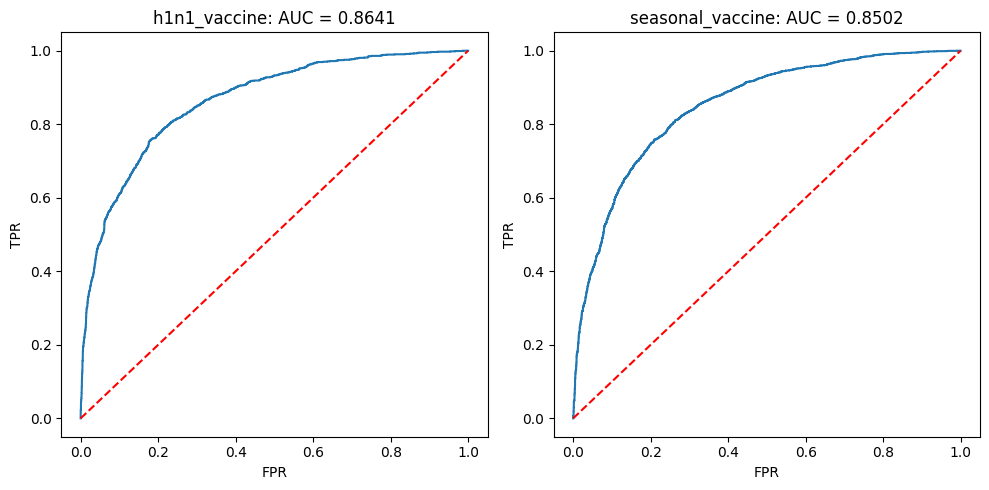

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    h1n1_y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    seasonal_y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

- AUC of 0.8641 for h1n1_vaccine: This indicates that the model has a good ability to distinguish between positive and negative classes. An AUC of 0.8641 is quite high, suggesting an effective model for predicting whether a person will receive the H1N1 vaccine.

- An AUC of 0.8502 indicates that the model performs well in predicting the seasonal vaccine, although it is a bit less accurate compared to the prediction for the H1N1 vaccine.

### **RESULTS: CONFUSION MATRIX**

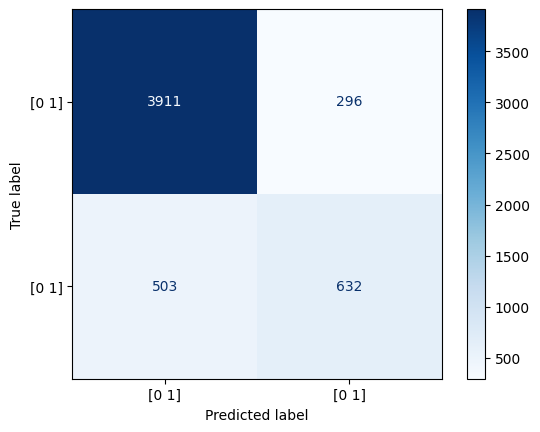

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4207
           1       0.68      0.56      0.61      1135

    accuracy                           0.85      5342
   macro avg       0.78      0.74      0.76      5342
weighted avg       0.84      0.85      0.84      5342



In [108]:
# h1n1_vaccine
cm = metrics.confusion_matrix(h1n1_y_test['h1n1_vaccine'], h1n1_preds_predict[:, 0])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=h1n1_estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(h1n1_y_test['h1n1_vaccine'], h1n1_preds_predict[:, 0]))

In summary, the model performs well overall, with a precision of 0.89 for class 0 and 0.68 for class 1, meaning it is more accurate at predicting class 0. The recall is higher for class 0 (0.93) than for class 1 (0.56) (the model detects class 0 instances better).

The overall accuracy is 0.85, and the F1-score is quite good, especially for class 0, suggesting a good balance between precision and recall. However, the model struggles to correctly identify class 1, as seen in its lower precision and recall for this class.

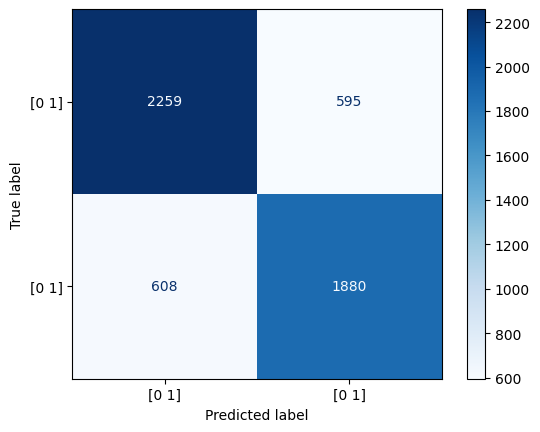

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2854
           1       0.76      0.76      0.76      2488

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



In [109]:
# seasonal_vaccine
cm = metrics.confusion_matrix(seasonal_y_test['seasonal_vaccine'], seasonal_preds_predict[:, 1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=seasonal_estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(seasonal_y_test['seasonal_vaccine'], seasonal_preds_predict[:, 1]))

In summary, the model performs fairly well, with a precision of 0.79 for class 0 and 0.76 for class 1, meaning it is slightly more accurate at predicting class 0. The recall is also similar for both classes, with 0.79 for class 0 and 0.76 for class 1, showing that the model detects both classes fairly well.

The overall accuracy is 0.77, and the F1-score is the same for both classes (0.79 for class 0 and 0.76 for class 1), indicating a decent balance between precision and recall. The results are consistent across both classes, with the model performing similarly for both.

### **FIT AND PREDICT RESULTS FOR COMPETITION UPLOAD**

The models (one for each prediction) are trained for the competition.

In [110]:
h1n1_estimators.fit(h1n1_X_train_df, training_set_labels_df)
h1n1_preds = h1n1_estimators.predict_proba(h1n1_X_test_df)
h1n1_preds

[array([[0.78345689, 0.21654311],
        [0.94609708, 0.05390292],
        [0.69158596, 0.30841404],
        ...,
        [0.81621611, 0.18378389],
        [0.93572156, 0.06427844],
        [0.41985721, 0.58014279]]),
 array([[0.5811244 , 0.4188756 ],
        [0.96812511, 0.03187489],
        [0.2537384 , 0.7462616 ],
        ...,
        [0.75008439, 0.24991561],
        [0.6042732 , 0.3957268 ],
        [0.52587626, 0.47412374]])]

In [111]:
seasonal_estimators.fit(seasonal_X_train_df, training_set_labels_df)
seasonal_preds = seasonal_estimators.predict_proba(seasonal_X_test_df)
seasonal_preds

[array([[0.79638341, 0.20361659],
        [0.96975927, 0.03024073],
        [0.72792962, 0.27207038],
        ...,
        [0.59175655, 0.40824345],
        [0.90406729, 0.09593271],
        [0.51228976, 0.48771024]]),
 array([[0.66020041, 0.33979959],
        [0.98913944, 0.01086056],
        [0.2452151 , 0.7547849 ],
        ...,
        [0.64494301, 0.35505699],
        [0.53473703, 0.46526297],
        [0.28017526, 0.71982474]])]

A dataframe is created with the predictions.

In [112]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': h1n1_preds[0][:,1],
        'seasonal_vaccine':seasonal_preds[1][:,1],
    },
    index=h1n1_X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.216543,0.339800
26708,0.053903,0.010861
26709,0.308414,0.754785
26710,0.700445,0.883599
26711,0.455824,0.569967


Export the CSV.

In [114]:
y_preds.to_csv('../results/pred_random_forest_output.csv', index = True)